Plot a time series of a given variable obtained from the WMOP model.

In [250]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import logging
import datetime
import os
from geopy.distance import vincenty
from calendar import monthrange
from scipy import interpolate
from matplotlib import rcParams
from matplotlib import dates
import time
%matplotlib inline

In [259]:
rcParams.update({'font.size': 20})
monthloc = dates.MonthLocator()  # every month
dayloc = dates.DayLocator(interval=6)
dayfmt = dates.DateFormatter('%d %B')

# Logging 

In [231]:
def configure_logging():
    logger = logging.getLogger("timeseries_logger")
    logger.setLevel(logging.WARNING)
    # Format for our loglines
    formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    # Setup console logging
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    # Setup file logging as well
    fh = logging.FileHandler('/home/ctroupin/logs/WMOP_timeseriesplot.log')
    fh.setLevel(logging.DEBUG)
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    return logger

# Input parameters

In [310]:
yearlist = [2014, 2015, 2016]
monthlist = [10, 11]
loninterp, latinterp = 0.783667, 38.82445
variable = 'sea_surface_temperature'

# Functions

We create a function to extract the time series of a given parameter for the year and month of interest 

In [311]:
logger = configure_logging()

In [312]:
def get_index_neighbour(coordinates, lon, lat):
    '''
    Get the indices of the coordinates corresponding to the closest points around the point of interest
    imin is the index of the closest longitude grid point smaller than the point of interest
    jmin is the index of the closest latitude grid point smaller than the point of interest
    
    (imin, jmin+1)______________(imin+1, jmin+1)
    |                                  |
    |                      x           |
    |                                  |
    |__________________________________|
    (imin, jmin)                (imin+1, jmin) 
    '''
    deltalon = abs(lon - coordinates[0])
    deltalat = abs(lat - coordinates[1])

    imin = np.argmin(deltalon)
    jmin = np.argmin(deltalat)

    if lon[imin] - coordinates[0] > 0.:   # closest grid point on the right of the point of interest
        imin -= 1

    if lat[jmin] - coordinates[1] > 0.:   # closest grid point on the above of the point of interest
        jmin -= 1
    return imin, jmin

In [313]:
def get_coefficients(coordinates, lon, lat, imin, jmin):
    '''Get the coefficient to perform an inverse distance interpolation 
       using the four closest points.
       The order of the coefficients is shown on the schema.
       
       (1)_______(2)
       |          |
       |       x  |
       |          |
       |__________|
       (0)       (3) 
    '''
    dist = np.array((vincenty(coordinates, (lon[imin], lat[jmin])).kilometers,
                     vincenty(coordinates, (lon[imin], lat[jmin+1])).kilometers,
                     vincenty(coordinates, (lon[imin+1], lat[jmin+1])).kilometers,
                     vincenty(coordinates, (lon[imin+1], lat[jmin])).kilometers))
    
    if any(dist==0):
        invdist = np.zeros(4)
        invdist[dist==0] = 1.
    else:
        invdist = 1. / dist
    
    return invdist / invdist.sum()

In [314]:
def get_variable_WMOP(variable, lon, lat, year, month):
    '''
    Extract a time series for the selected variable 
    at the location specified by lon, lat 
    for the period specified year and month.
    The function returns two arrays, one contains the dates, 
    the other stores the time series
    '''

    # Create empty arrays
    WMOPdate = np.array([])
    WMOPvariable = np.array([])

    # Convert integers to strings for the data
    yyyy = str(year).zfill(4)
    mm = str(month).zfill(2)

    # Generate thredds directory name
    threddsdir = ("http://thredds.socib.es/thredds/dodsC/operational_models/oceanographical/"
                  "hydrodynamics/wmop/{0}/{1}/".format(yyyy, mm))

    # Get number of days for that month and year combination
    numdays = monthrange(year, month)[-1]

    # Loop on the days
    
    if (year == datetime.datetime.today().year) & (month == datetime.datetime.today().month):
        daymax = min(datetime.datetime.today().day, numdays + 1)
    else:
        daymax = numdays + 1
        
    for days in range(1, daymax):
        
        print days
        
        # Create file name
        dd = str(days).zfill(2)
        wmopfile = "roms_wmop_{0}{1}{2}.nc".format(yyyy, mm, dd)
        
        
        logger.info("Working on {0}".format(wmopfile))

        # Get the interpolation coefficients only for the 1st step
        if days == 1:
            try:
                with netCDF4.Dataset(os.path.join(threddsdir, wmopfile)) as nc:
                    # Load lon and lat
                    lon_variable = nc.get_variables_by_attributes(standard_name='longitude')
                    lon_values = lon_variable[0][:]
                    lat_variable = nc.get_variables_by_attributes(standard_name='latitude')
                    lat_values = lat_variable[0][:]

                    # Get coefficients 
                    i, j = get_index_neighbour((loninterp, latinterp), lon_values, lat_values)
                    invdist = get_coefficients((loninterp, latinterp), lon_values, lat_values, i, j)
            except IOError:
                
                logger.error('File does not exist')

        try:
            with netCDF4.Dataset(os.path.join(threddsdir, wmopfile)) as nc:
                time_variable = nc.variables['ocean_time']
                time_converted = netCDF4.num2date(time_variable[:8], time_variable.units)

                field_variable = nc.get_variables_by_attributes(standard_name=variable)
                field_values = field_variable[0][:8, j:j+2, i:i+2]
                field_units = variable_name[0].units
            
            field_interp = invdist[0] * field_values[:, 0, 0] + invdist[1] * field_values[:, 1, 0] + \
                       invdist[2] * field_values[:, 1, 1] + invdist[3] * field_values[:, 0, 1]
            logger.debug(field_interp.shape)

            WMOPdate = np.concatenate((WMOPdate, time_converted), axis=0)
            WMOPvariable = np.concatenate((WMOPvariable, field_interp), axis=0)
        
        except IOError:
            logger.error('File does not exist')
            
    return WMOPdate, WMOPvariable

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29

2016-11-08 16:33:14,277 - timeseries_logger - ERROR - File does not exist
2016-11-08 16:33:14,277 - timeseries_logger - ERROR - File does not exist
2016-11-08 16:33:14,277 - timeseries_logger - ERROR - File does not exist
2016-11-08 16:33:14,277 - timeseries_logger - ERROR - File does not exist
2016-11-08 16:33:14,277 - timeseries_logger - ERROR - File does not exist
2016-11-08 16:33:14,277 - timeseries_logger - ERROR - File does not exist
ERROR:timeseries_logger:File does not exist



30
31
1
2
3
4
5
6
7


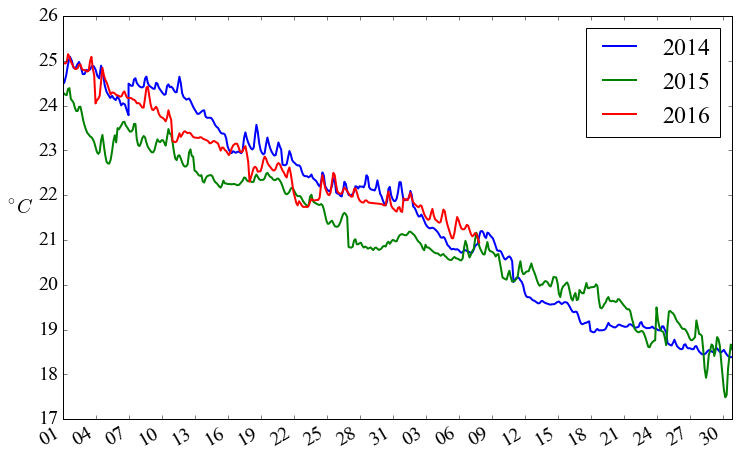

In [315]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for year in yearlist:
    
    WMOPdate_all, WMOPvariable_all = np.array([]), np.array([])
    
    for month in monthlist:
        
        WMOPdate, WMOPvariable = get_variable_WMOP(variable, loninterp, latinterp, year, month)
        WMOPdate_all = np.concatenate((WMOPdate_all, WMOPdate), axis=0)
        WMOPvariable_all = np.concatenate((WMOPvariable_all, WMOPvariable), axis=0)
        
    # Modify the year to overlay plots
    for ii in range(0, len(WMOPdate_all)):
        WMOPdate_all[ii] = WMOPdate_all[ii].replace(year=yearlist[0])
        
    plt.plot(WMOPdate_all, WMOPvariable_all, label=str(year))

plt.legend()
plt.ylabel('$^{\circ}C$', rotation=0, ha='right')
ax.xaxis.set_major_locator(dayloc)
ax.xaxis.set_major_formatter(dayfmt)
fig.autofmt_xdate()
plt.show()

In [316]:
month

11

In [317]:
year

2016